# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import re
import pandas as pd
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import CRF, scorers,metrics
import warnings
warnings.filterwarnings('ignore')
model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1870 sha256=94fb6b07eb7c50f10a51e2e94f1587b63009cd9b17f629c9c82dc4e6483b3e0c
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

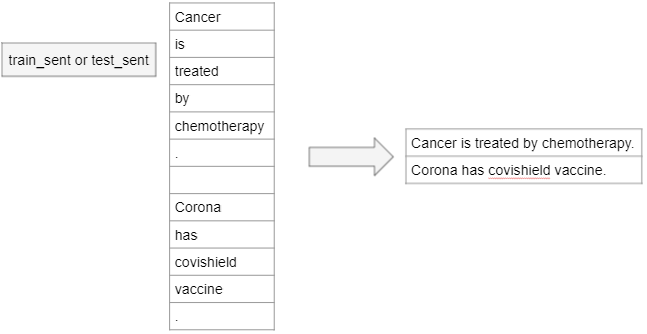

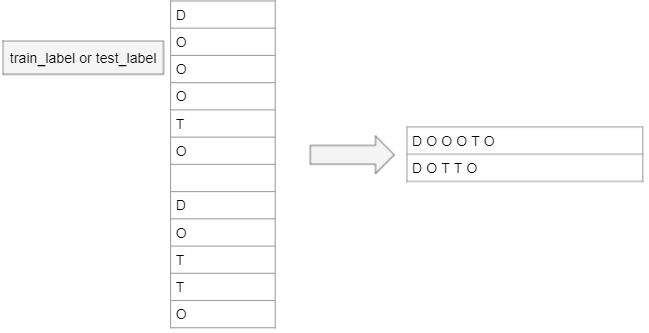

In [2]:
def createDataFramefromFile(file_name, df_col_name):

  import re
  file = open(file_name, "r")
  wordlist = []
  sent = []
  for word in file:
    if word == '\n':
      # sentence complete store previous sent
      full_sent = ' '.join(wordlist)
      sent.append(full_sent)
      full_sent=''
      wordlist = []
    else:
      w = word.replace('\n','')
      wordlist.append(w)

  df = pd.DataFrame({df_col_name:sent})
  return df

In [3]:
df_train_sent = createDataFramefromFile('/content/train_sent', 'train_sent')
df_train_sent['index'] = df_train_sent.index
print(df_train_sent)

                                             train_sent  index
0     All live births > or = 23 weeks at the Univers...      0
1     The total cesarean rate was 14.4 % ( 344 of 23...      1
2     Abnormal presentation was the most common indi...      2
3     The `` corrected '' cesarean rate ( maternal-f...      3
4     Arrest of dilation was the most common indicat...      4
...                                                 ...    ...
2594  Special report : comparative efficacy of diffe...   2594
2595  Special report : pressure-reducing support sur...   2595
2596  External counterpulsation for treatment of chr...   2596
2597  Intra-articular hyaluronan injections for trea...   2597
2598               Pneumococcal vaccine : a second look   2598

[2599 rows x 2 columns]


In [4]:
# Similarly, Create Train_Label, test_sent and test_label dfs
df_train_label = createDataFramefromFile('/content/train_label', 'train_label')
df_train_label['index'] = df_train_label.index
print(df_train_label)

                                            train_label  index
0     O O O O O O O O O O O O O O O O O O O O O O O ...      0
1     O O O O O O O O O O O O O O O O O O O O O O O O O      1
2                         O O O O O O O O O O O O O O O      2
3     O O O O O O O O O O O O O O O O O O O O O O O ...      3
4           O O O O O O O O O O O O O O O O O O O O O O      4
...                                                 ...    ...
2594                  O O O O O O O O O T T T O O O O D   2594
2595                O O O T T T O O O O O O D D O O O O   2595
2596                                  T T O O O D D D D   2596
2597                                T T T O O O D O O O   2597
2598                                        D T O O O O   2598

[2599 rows x 2 columns]


In [5]:
# Merge the two to form one dataset of all train data
df_train_data = pd.merge(df_train_sent, df_train_label, on="index")
print(df_train_data)

                                             train_sent  index  \
0     All live births > or = 23 weeks at the Univers...      0   
1     The total cesarean rate was 14.4 % ( 344 of 23...      1   
2     Abnormal presentation was the most common indi...      2   
3     The `` corrected '' cesarean rate ( maternal-f...      3   
4     Arrest of dilation was the most common indicat...      4   
...                                                 ...    ...   
2594  Special report : comparative efficacy of diffe...   2594   
2595  Special report : pressure-reducing support sur...   2595   
2596  External counterpulsation for treatment of chr...   2596   
2597  Intra-articular hyaluronan injections for trea...   2597   
2598               Pneumococcal vaccine : a second look   2598   

                                            train_label  
0     O O O O O O O O O O O O O O O O O O O O O O O ...  
1     O O O O O O O O O O O O O O O O O O O O O O O O O  
2                         O O O O

In [6]:
df_test_sent = createDataFramefromFile('/content/test_sent', 'test_sent')
df_test_sent['index'] = df_test_sent.index
print(df_test_sent)

                                              test_sent  index
0     Furthermore , when all deliveries were analyze...      0
1     As the ambient temperature increases , there i...      1
2     The daily high temperature ranged from 71 to 1...      2
3     There was a significant correlation between th...      3
4     Fluctuations in ambient temperature are invers...      4
...                                                 ...    ...
1051  Reduction of vasoreactivity and thrombogenicit...   1051
1052  Effects of ultrasound energy on total peripher...   1052
1053  High-dose chemotherapy with autologous stem-ce...   1053
1054  `` Tandem '' high-dose chemoradiotherapy with ...   1054
1055  Intravenous immune globulin for recurrent spon...   1055

[1056 rows x 2 columns]


In [7]:
# Similarly, Create Train_Label, test_sent and test_label dfs
df_test_label = createDataFramefromFile('/content/test_label', 'test_label')
df_test_label['index'] = df_test_label.index
print(df_test_label)

                                             test_label  index
0     O O O O O O O O O O O O O O O O O O O O O O O ...      0
1                 O O O O O O O O O O O O O O O O O O O      1
2       O O O O O O O O O O O O O O O O O O O O O O O O      2
3     O O O O O O O O O O O O O O O O O O O O O O O ...      3
4                                 O O O O O O O O O O O      4
...                                                 ...    ...
1051                          O O D O D O T T O O O T T   1051
1052                    O O T T O D D D D O O O O O O O   1052
1053                                T T T T T T O D D D   1053
1054              T T T T T T T T T O O O O O O O O D D   1054
1055                                      T T T O D D D   1055

[1056 rows x 2 columns]


In [8]:
# Merge the two to form one dataset of all train data
df_test_data = pd.merge(df_test_sent, df_test_label, on="index")
print(df_test_data)

                                              test_sent  index  \
0     Furthermore , when all deliveries were analyze...      0   
1     As the ambient temperature increases , there i...      1   
2     The daily high temperature ranged from 71 to 1...      2   
3     There was a significant correlation between th...      3   
4     Fluctuations in ambient temperature are invers...      4   
...                                                 ...    ...   
1051  Reduction of vasoreactivity and thrombogenicit...   1051   
1052  Effects of ultrasound energy on total peripher...   1052   
1053  High-dose chemotherapy with autologous stem-ce...   1053   
1054  `` Tandem '' high-dose chemoradiotherapy with ...   1054   
1055  Intravenous immune globulin for recurrent spon...   1055   

                                             test_label  
0     O O O O O O O O O O O O O O O O O O O O O O O ...  
1                 O O O O O O O O O O O O O O O O O O O  
2       O O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset

In [9]:
print(df_train_data[['train_sent']].shape)
print(df_test_data[['test_sent']].shape)

(2599, 1)
(1056, 1)


### Count the number of lines of labels in the processed train and test dataset.

In [10]:
print(df_train_data[['train_label']].shape)
print(df_test_data[['test_label']].shape)

(2599, 1)
(1056, 1)


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [11]:
import spacy
from collections import Counter
import pandas as pd

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_and_count_nouns_proper_nouns(text):
    """
    Extract and count NOUN and PROPN tokens from the text.

    Args:
    text (str): The text to process.

    Returns:
    Counter: Frequency counter for NOUN and PROPN tokens.
    """
    doc = nlp(text)
    tokens = [token.text for token in doc if token.pos_ in {'NOUN', 'PROPN'}]
    token_freq = Counter(tokens)
    return token_freq

def process_texts(text_series):
    """
    Process a series of texts to extract and count NOUN and PROPN tokens.

    Args:
    text_series (pd.Series): Series containing text data.

    Returns:
    Counter: Token frequency counter.
    """
    overall_counter = Counter()

    # Debug: Check type of text_series
    print("Type of text_series:", type(text_series))

    for text in text_series:


        if isinstance(text, str):  # Ensure text is a string
            token_freq = extract_and_count_nouns_proper_nouns(text)
            overall_counter.update(token_freq)
        else:
            print("Warning: Non-string data encountered.")

    return overall_counter

# Example DataFrame (replace with your actual DataFrame)
# Check if the DataFrame and column exist
if isinstance(df_train_data, pd.DataFrame):
    if 'train_sent' in df_train_data.columns:
        text_series = df_train_data['train_sent']

        # Debug: Print first few rows of text_series
        print("First few rows of text_series:")
        print(text_series.head())

        token_frequency = process_texts(text_series)

        # Print the frequencies
        print("Token frequencies for NOUN and PROPN tokens:")
        for token, freq in token_frequency.items():
            print(f"Token: '{token}' | Frequency: {freq}")
    else:
        print("Error: The column 'train_sent' does not exist in the DataFrame.")
else:
    print("Error: df_train_data is not a pandas DataFrame.")


Streaming output truncated to the last 5000 lines.
Token: 'HLA' | Frequency: 4
Token: '6p21.3' | Frequency: 1
Token: 'APOE' | Frequency: 3
Token: 'MBP' | Frequency: 1
Token: 'myelin' | Frequency: 2
Token: 'SUBJECTS' | Frequency: 4
Token: 'total' | Frequency: 5
Token: 'individuals' | Frequency: 4
Token: 'California' | Frequency: 2
Token: 'Beijing' | Frequency: 1
Token: 'China' | Frequency: 1
Token: 'Chi2' | Frequency: 1
Token: 'Testing' | Frequency: 1
Token: 'alleles' | Frequency: 2
Token: 'haplotypes' | Frequency: 3
Token: 'Haplotype' | Frequency: 1
Token: 'frequencies' | Frequency: 2
Token: 'likelihood' | Frequency: 3
Token: 'effect' | Frequency: 43
Token: 'class' | Frequency: 10
Token: 'II' | Frequency: 14
Token: 'DR2' | Frequency: 1
Token: 'DRB1' | Frequency: 3
Token: 'DQA1' | Frequency: 1
Token: 'contributions' | Frequency: 2
Token: 'DQB1' | Frequency: 1
Token: 'distribution' | Frequency: 7
Token: 'D19S178' | Frequency: 1
Token: 'D19S574' | Frequency: 1
Token: 'APOC2' | Frequency: 

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [12]:
import spacy
from collections import Counter
import pandas as pd

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_tokens_and_tags(text):
    """
    Process the text to extract tokens and their PoS tags.

    Args:
    text (str): A text string to process.

    Returns:
    list of tuples: Each tuple contains a token and its PoS tag.
    """
    doc = nlp(text)
    # Extract tokens and their PoS tags
    tokens_and_tags = [(token.text, token.pos_) for token in doc]
    return tokens_and_tags

def process_texts(text_series):
    """
    Process a series of texts to extract tokens and their PoS tags.

    Args:
    text_series (pd.Series): A pandas Series where each entry is a text string.

    Returns:
    Counter: A Counter object with token frequencies.
    """
    noun_counter = Counter()
    proper_noun_counter = Counter()

    for text in text_series:
        if isinstance(text, str):  # Ensure text is a string
            tokens_and_tags = extract_tokens_and_tags(text)
            for token, pos in tokens_and_tags:
                if pos == 'NOUN':
                    noun_counter[token] += 1
                elif pos == 'PROPN':
                    proper_noun_counter[token] += 1
        else:
            print("Warning: Non-string data encountered.")

    return noun_counter, proper_noun_counter

# Example DataFrame (replace with your actual DataFrame loading method)

if 'train_sent' in df_train_data.columns:
    # Extract the text column as a Series
    text_series = df_train_data['train_sent']

    # Process the texts and get token frequencies
    noun_counts, proper_noun_counts = process_texts(text_series)

    # Print the top 25 most common NOUN tokens
    print("\nTop 25 most common NOUN tokens:")
    for token, freq in noun_counts.most_common(25):
        print(f"Token: '{token}' | Frequency: {freq}")

    # Print the top 25 most common PROPN tokens
    print("\nTop 25 most common PROPN tokens:")
    for token, freq in proper_noun_counts.most_common(25):
        print(f"Token: '{token}' | Frequency: {freq}")
else:
    print("Error: The column 'train_sent' does not exist in the DataFrame.")



Top 25 most common NOUN tokens:
Token: 'patients' | Frequency: 354
Token: 'treatment' | Frequency: 195
Token: '%' | Frequency: 161
Token: 'cancer' | Frequency: 135
Token: 'therapy' | Frequency: 120
Token: 'disease' | Frequency: 105
Token: 'study' | Frequency: 103
Token: 'cell' | Frequency: 99
Token: 'lung' | Frequency: 86
Token: 'chemotherapy' | Frequency: 65
Token: 'group' | Frequency: 63
Token: 'effects' | Frequency: 61
Token: 'gene' | Frequency: 54
Token: 'results' | Frequency: 54
Token: 'use' | Frequency: 53
Token: 'surgery' | Frequency: 51
Token: 'survival' | Frequency: 50
Token: 'risk' | Frequency: 49
Token: 'women' | Frequency: 48
Token: 'care' | Frequency: 47
Token: 'analysis' | Frequency: 47
Token: 'children' | Frequency: 47
Token: 'activity' | Frequency: 47
Token: 'rate' | Frequency: 46
Token: 'cases' | Frequency: 46

Top 25 most common PROPN tokens:
Token: 'TO_SEE' | Frequency: 54
Token: 'HIV' | Frequency: 23
Token: 'METHODS' | Frequency: 19
Token: 'A' | Frequency: 16
Token

## Defining features for CRF





In [13]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features



## Getting the features

### Write a code/function to get the features for a sentence

In [14]:
# Write a code to get features for a sentence.
# def get_features_for_sentence(sentence):

#     features_list = []

#     for pos in range(len(sentence)):
#         features = getFeaturesForOneWord(sentence, pos)
#         features_list.append(features)

#     return features_list



def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]


In [15]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = df_train_data.loc[5]['train_sent']
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'BEG']

In [16]:
# First word in sentence
features[1]

['word.lower=rates',
 'word[-3:]=tes',
 'word[-2:]=es',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=cesarean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=True']

In [17]:
# First word in sentence
features[23]

['word.lower=age',
 'word[-3:]=age',
 'word[-2:]=ge',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=gestational',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False',
 'END']

### Write a code/function to get the labels of a sentence

In [18]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [19]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in df_train_data['train_sent']]
X_test = [getFeaturesForOneSentence(sentence) for sentence in df_test_data['test_sent']]

### Define the labels as the target variable for test and the train dataset

In [20]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in df_train_data['train_label']]
Y_test = [getLabelsInListForOneSentence(labels) for labels in df_test_data['test_label']]

## Build the CRF Model

In [21]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [22]:
# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)

In [23]:
# get first 5 sentences and their predicted tags
for id in range (0, 5):
  print("Sentence:",df_test_data.loc[id]['test_sent'])
  print("Original Labels:", Y_test[id])
  print("Predicted Labels:", Y_pred[id])

Sentence: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Original Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Original Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [24]:
# Calculate the f1 score using the test data
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9044158773940203

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

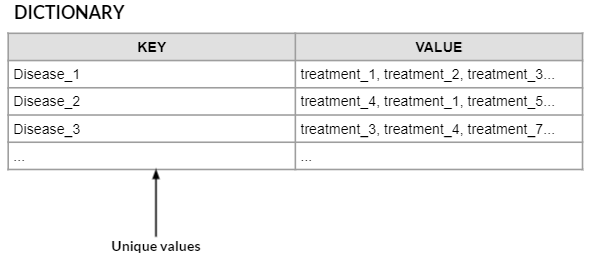

In [25]:
# Get the sentences and predictions where we have labels (T) and (D) in test data
# Define local LIST variables to hold the diseases and its treatment
varDisease = []
varTreatment = []
for id in range(0,len(df_test_data)):
  length = len(Y_pred[id])
  vDisease = '' # local string variable for each sentence and prediction
  vTreat = ''
  has_disease = have_treatment = False


  str = df_test_data.loc[id]['test_sent']
  # First pass to detect (D)
  #string = 'Disease: '
  for i in range(0,length):
    if (Y_pred[id][i]=='D'):
      has_disease = True
      vDisease = vDisease + str.split()[i] + " "

  # DO a second pass to get all the Treatments for the above Disease
  # Doing it twice so  that I can get teh Disease first and then the treatment, Maybe an efficient way exists
  #string = string + '; Treatment: '
  for i in range (0,length):
    if (Y_pred[id][i]=='T'):
      have_treatment = True
      vTreat = vTreat + str.split()[i] + " "

  # Print only if it not empty
  if (has_disease == True) & (have_treatment == True):
    #Append to the list if you found both disease and its treatment
    varDisease.append(vDisease)
    varTreatment.append(vTreat)

# At the end add to a run against the test data, create a df from the individual lists
df_disease_treatment = pd.DataFrame({'Disease':varDisease, 'Treatment':varTreatment})
df_disease_treatment.head(5)

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,cellulitis,G-CSF therapy intravenous antibiotic treatment


In [26]:
df_disease_treatment.shape

(116, 2)

In [27]:
print(len(df_disease_treatment.Disease.unique()))

106


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [28]:
df_disease_treatment[df_disease_treatment.Disease.str.strip() == "hereditary retinoblastoma"]

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
